In [25]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from string import punctuation
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
from string import punctuation
custom = stop_words+list(punctuation)
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def my_tokenizer(s):
    s = s.lower()
    tokens = nltk.tokenize.word_tokenize(s)
    tokens = [t for t in tokens if len(t)>2] #remove words lesser than 2 in length
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] #lemmatize words
    tokens = [t for t in tokens if t not in custom] #remove stopwords and punctuation
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove digits
    return tokens

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/NLP datasets/Consumer_Complaints_big.csv')
df = df[["Consumer complaint narrative"]]
df = df.dropna()
df = df[:10]

In [0]:
df.columns = ["text"]
text = df["text"].tolist()
text = [my_tokenizer(s) for s in text]

In [0]:
import gensim
from gensim.corpora import dictionary
from gensim import corpora
from pprint import pprint


In [31]:
id2word = corpora.Dictionary(text)
print(id2word)

Dictionary(242 unique tokens: ['abide', 'abusive', 'account', 'apartment', 'application']...)


In [0]:
mycorpus = [id2word.doc2bow(s) for s in text]

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=mycorpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [34]:
pprint(lda_model.print_topics())
doc_lda = lda_model[mycorpus]

[(0,
  '0.061*"xxxx" + 0.044*"account" + 0.044*"ha" + 0.036*"hollins" + '
  '0.036*"kent" + 0.019*"also" + 0.019*"social" + 0.019*"security" + '
  '0.019*"informed" + 0.019*"garnish"'),
 (1,
  '0.095*"xxxx" + 0.021*"dispute" + 0.021*"bill" + 0.021*"medical" + '
  '0.016*"phone" + 0.016*"collection" + 0.016*"time" + 0.016*"wa" + '
  '0.016*"amount" + 0.016*"financial"'),
 (2,
  '0.130*"xxxx" + 0.031*"credit" + 0.027*"account" + 0.027*"wa" + '
  '0.020*"fraudulent" + 0.016*"file" + 0.016*"ha" + 0.016*"report" + '
  '0.012*"collection" + 0.012*"information"'),
 (3,
  '0.107*"xxxx" + 0.028*"agency" + 0.028*"credit" + 0.023*"call" + '
  '0.023*"removed" + 0.017*"sign" + 0.017*"company" + 0.017*"equifax" + '
  '0.017*"satisfied" + 0.017*"one"')]


In [35]:
print('\nPerplexity: ', lda_model.log_perplexity(mycorpus))  # a measure of how good the model is. lower the better.


Perplexity:  -5.17835141777208


In [36]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6754899716404427


In [37]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, mycorpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.064465  0.089896       1        1  38.513599
1      0.105494 -0.008003       2        1  26.681475
3     -0.064833 -0.096899       3        1  23.878389
0      0.023803  0.015005       4        1  10.926541, topic_info=    Category       Freq     Term      Total  loglift  logprob
39   Default   6.000000       ha   6.000000  30.0000  30.0000
192  Default   2.000000  hollins   2.000000  29.0000  29.0000
194  Default   2.000000     kent   2.000000  28.0000  28.0000
2    Default  11.000000  account  11.000000  27.0000  27.0000
78   Default   5.000000   agency   5.000000  26.0000  26.0000
..       ...        ...      ...        ...      ...      ...
2     Topic4   2.566992  account  11.947860   0.6762  -3.1199
110   Topic4   0.611100   amount   3.259807   0.5398  -4.5552
169   Topic4   0.610955    month   3.389818   0.5005  -4.5554
77    Topic4   3.534873     xxxx  57.193970  -0.5698  -2.8000
139   Topic4   0.611356   letter   3.987977   0.3386  -4.5547

[197 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
163       1  0.700489      've
2         1  0.502182  account
2         2  0.167394  account
2         3  0.167394  account
2         4  0.251091  account
...     ...       ...      ...
241       2  0.733991     work
77        1  0.472078     xxxx
77        2  0.227297     xxxx
77        3  0.244781     xxxx
77        4  0.069937     xxxx

[193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

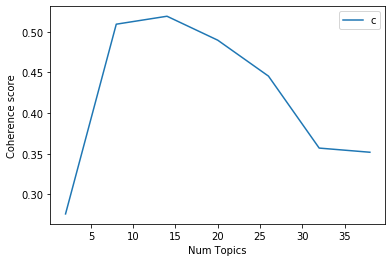

In [39]:
import os
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mycorpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=mycorpus, texts=text, start=2, limit=40, step=6)
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

Num Topics = 2  has Coherence Value of 0.2759
Num Topics = 8  has Coherence Value of 0.5094
Num Topics = 14  has Coherence Value of 0.5192
Num Topics = 20  has Coherence Value of 0.4897
Num Topics = 26  has Coherence Value of 0.4455
Num Topics = 32  has Coherence Value of 0.3569
Num Topics = 38  has Coherence Value of 0.3518
[(0,
  '0.004*"debt" + 0.004*"xxxx" + 0.004*"account" + 0.004*"credit" + '
  '0.004*"dispute" + 0.004*"agency" + 0.004*"still" + 0.004*"month" + '
  '0.004*"number" + 0.004*"call"'),
 (1,
  '0.004*"debt" + 0.004*"xxxx" + 0.004*"account" + 0.004*"credit" + '
  '0.004*"report" + 0.004*"month" + 0.004*"still" + 0.004*"ha" + 0.004*"time" '
  '+ 0.004*"dispute"'),
 (2,
  '0.051*"xxxx" + 0.041*"ha" + 0.037*"account" + 0.028*"kent" + '
  '0.026*"hollins" + 0.022*"amount" + 0.019*"agency" + 0.018*"payment" + '
  '0.017*"claim" + 0.016*"garnish"'),
 (3,
  '0.004*"debt" + 0.004*"xxxx" + 0.004*"account" + 0.004*"credit" + '
  '0.004*"agency" + 0.004*"dispute" + 0.004*"still" 

In [41]:
def format_topics_sentences(ldamodel=lda_model, corpus=mycorpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=mycorpus, texts=text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.9940,"xxxx, account, credit, wa, ha, file, collectio...","[duplicate, contacted, xxxx, xxxx, experian, f..."
1,1,4.0,0.5357,"account, credit, paid, number, still, authoriz...",[debt]
2,2,8.0,0.9727,"dispute, sign, credit, call, xxxx, karma, via,...","[call, dont, answer, call, call, day, long, ha..."
3,3,4.0,0.9629,"account, credit, paid, number, still, authoriz...","[provided, account, information, showed, debt,..."
4,4,6.0,0.6146,"xxxx, account, wa, bill, collection, medical, ...","[charge, credit, report, collection, agency, t..."
5,5,7.0,0.9902,"xxxx, account, credit, wa, ha, file, collectio...","[xxxx, xxxx, xxxx, xxxx, posted, collection, a..."
6,6,4.0,0.9643,"account, credit, paid, number, still, authoriz...","[xxxx, month, every, month, since, 've, reciev..."
7,7,8.0,0.9484,"dispute, sign, credit, call, xxxx, karma, via,...","[filed, dispute, credit, karma, file, another,..."
8,8,2.0,0.7964,"xxxx, ha, account, kent, hollins, amount, agen...","[today, recieved, letter, kent, hollins, accou..."
9,9,6.0,0.9903,"xxxx, account, wa, bill, collection, medical, ...","[visited, xxxx, xxxx, xxxx, xxxx, xxxx, illnes..."


In [42]:
def format_topics_sentences(ldamodel=lda_model, corpus=mycorpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=mycorpus, texts=text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.9940,"xxxx, account, credit, wa, ha, file, collectio...","[duplicate, contacted, xxxx, xxxx, experian, f..."
1,1,4.0,0.5357,"account, credit, paid, number, still, authoriz...",[debt]
2,2,8.0,0.9727,"dispute, sign, credit, call, xxxx, karma, via,...","[call, dont, answer, call, call, day, long, ha..."
3,3,4.0,0.9629,"account, credit, paid, number, still, authoriz...","[provided, account, information, showed, debt,..."
4,4,6.0,0.6144,"xxxx, account, wa, bill, collection, medical, ...","[charge, credit, report, collection, agency, t..."
5,5,7.0,0.9902,"xxxx, account, credit, wa, ha, file, collectio...","[xxxx, xxxx, xxxx, xxxx, posted, collection, a..."
6,6,4.0,0.9643,"account, credit, paid, number, still, authoriz...","[xxxx, month, every, month, since, 've, reciev..."
7,7,8.0,0.9484,"dispute, sign, credit, call, xxxx, karma, via,...","[filed, dispute, credit, karma, file, another,..."
8,8,2.0,0.7979,"xxxx, ha, account, kent, hollins, amount, agen...","[today, recieved, letter, kent, hollins, accou..."
9,9,6.0,0.9903,"xxxx, account, wa, bill, collection, medical, ...","[visited, xxxx, xxxx, xxxx, xxxx, xxxx, illnes..."


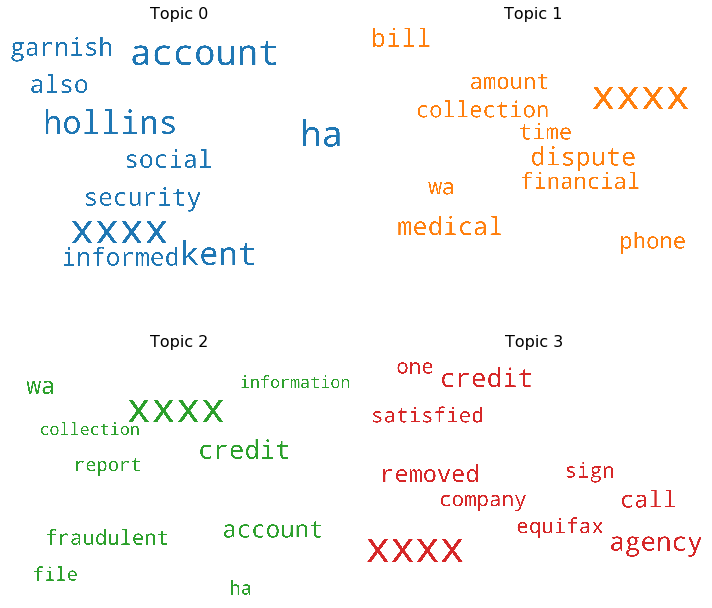

In [43]:
!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

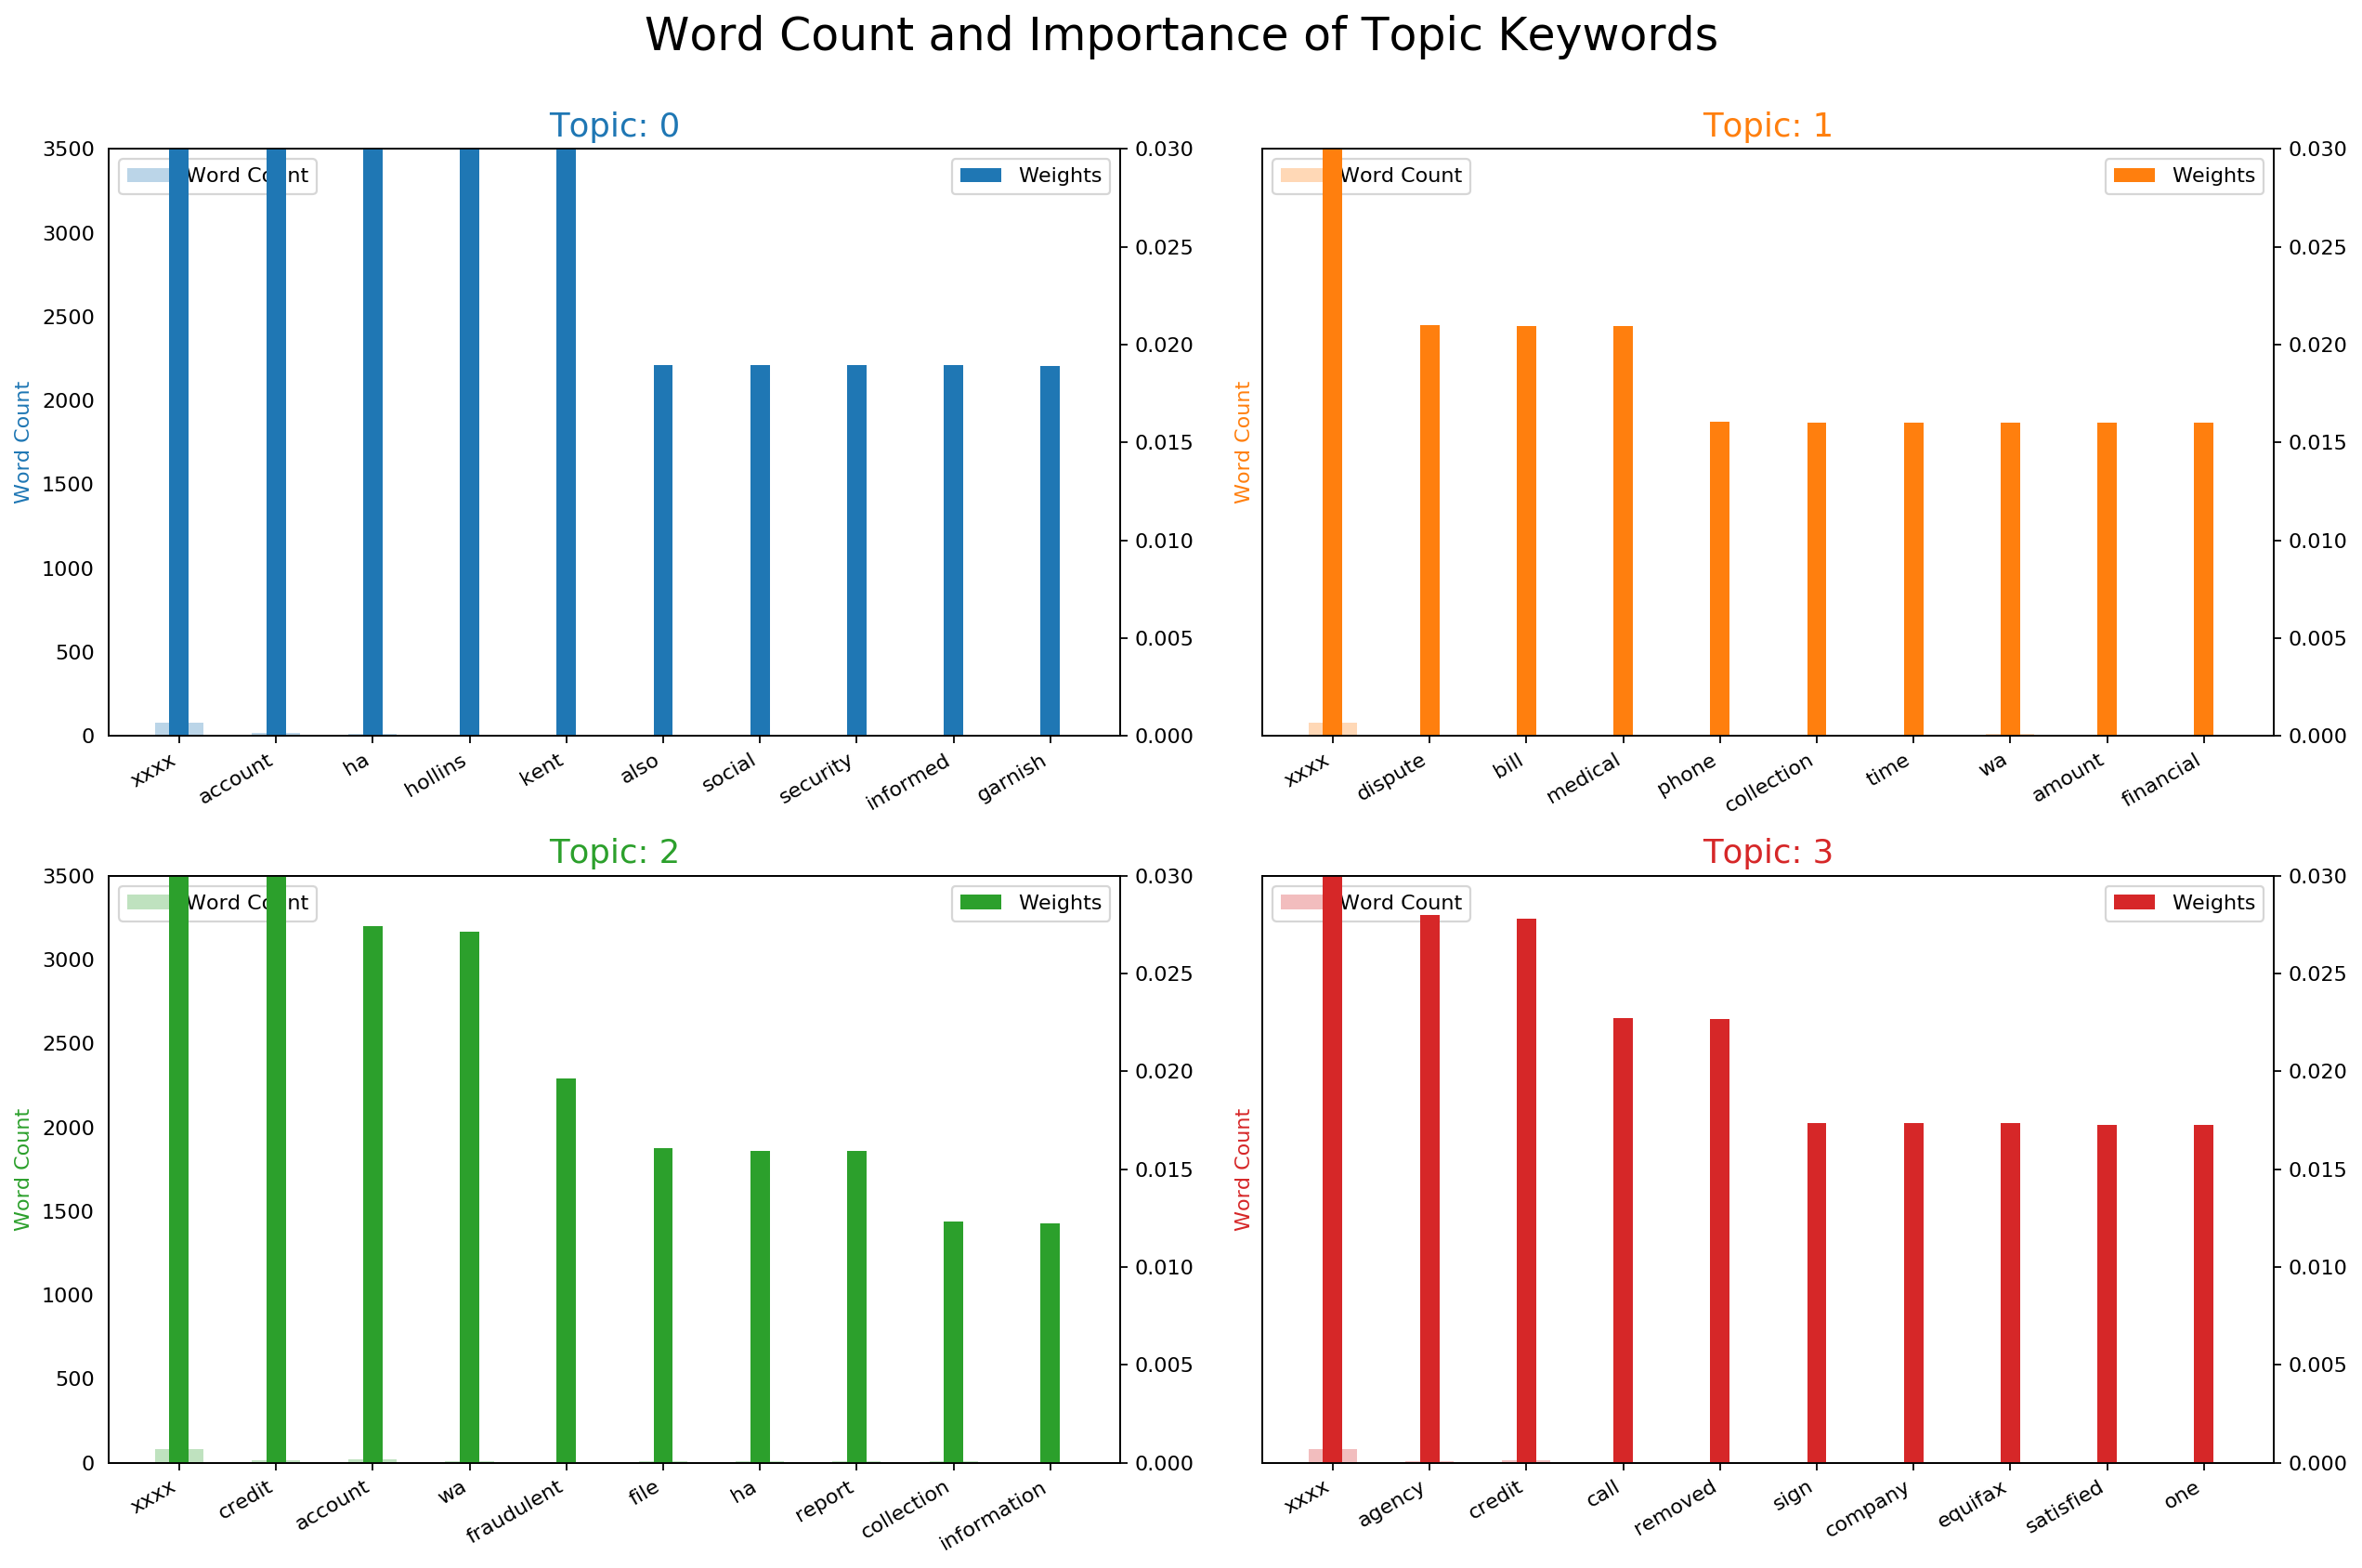

In [44]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

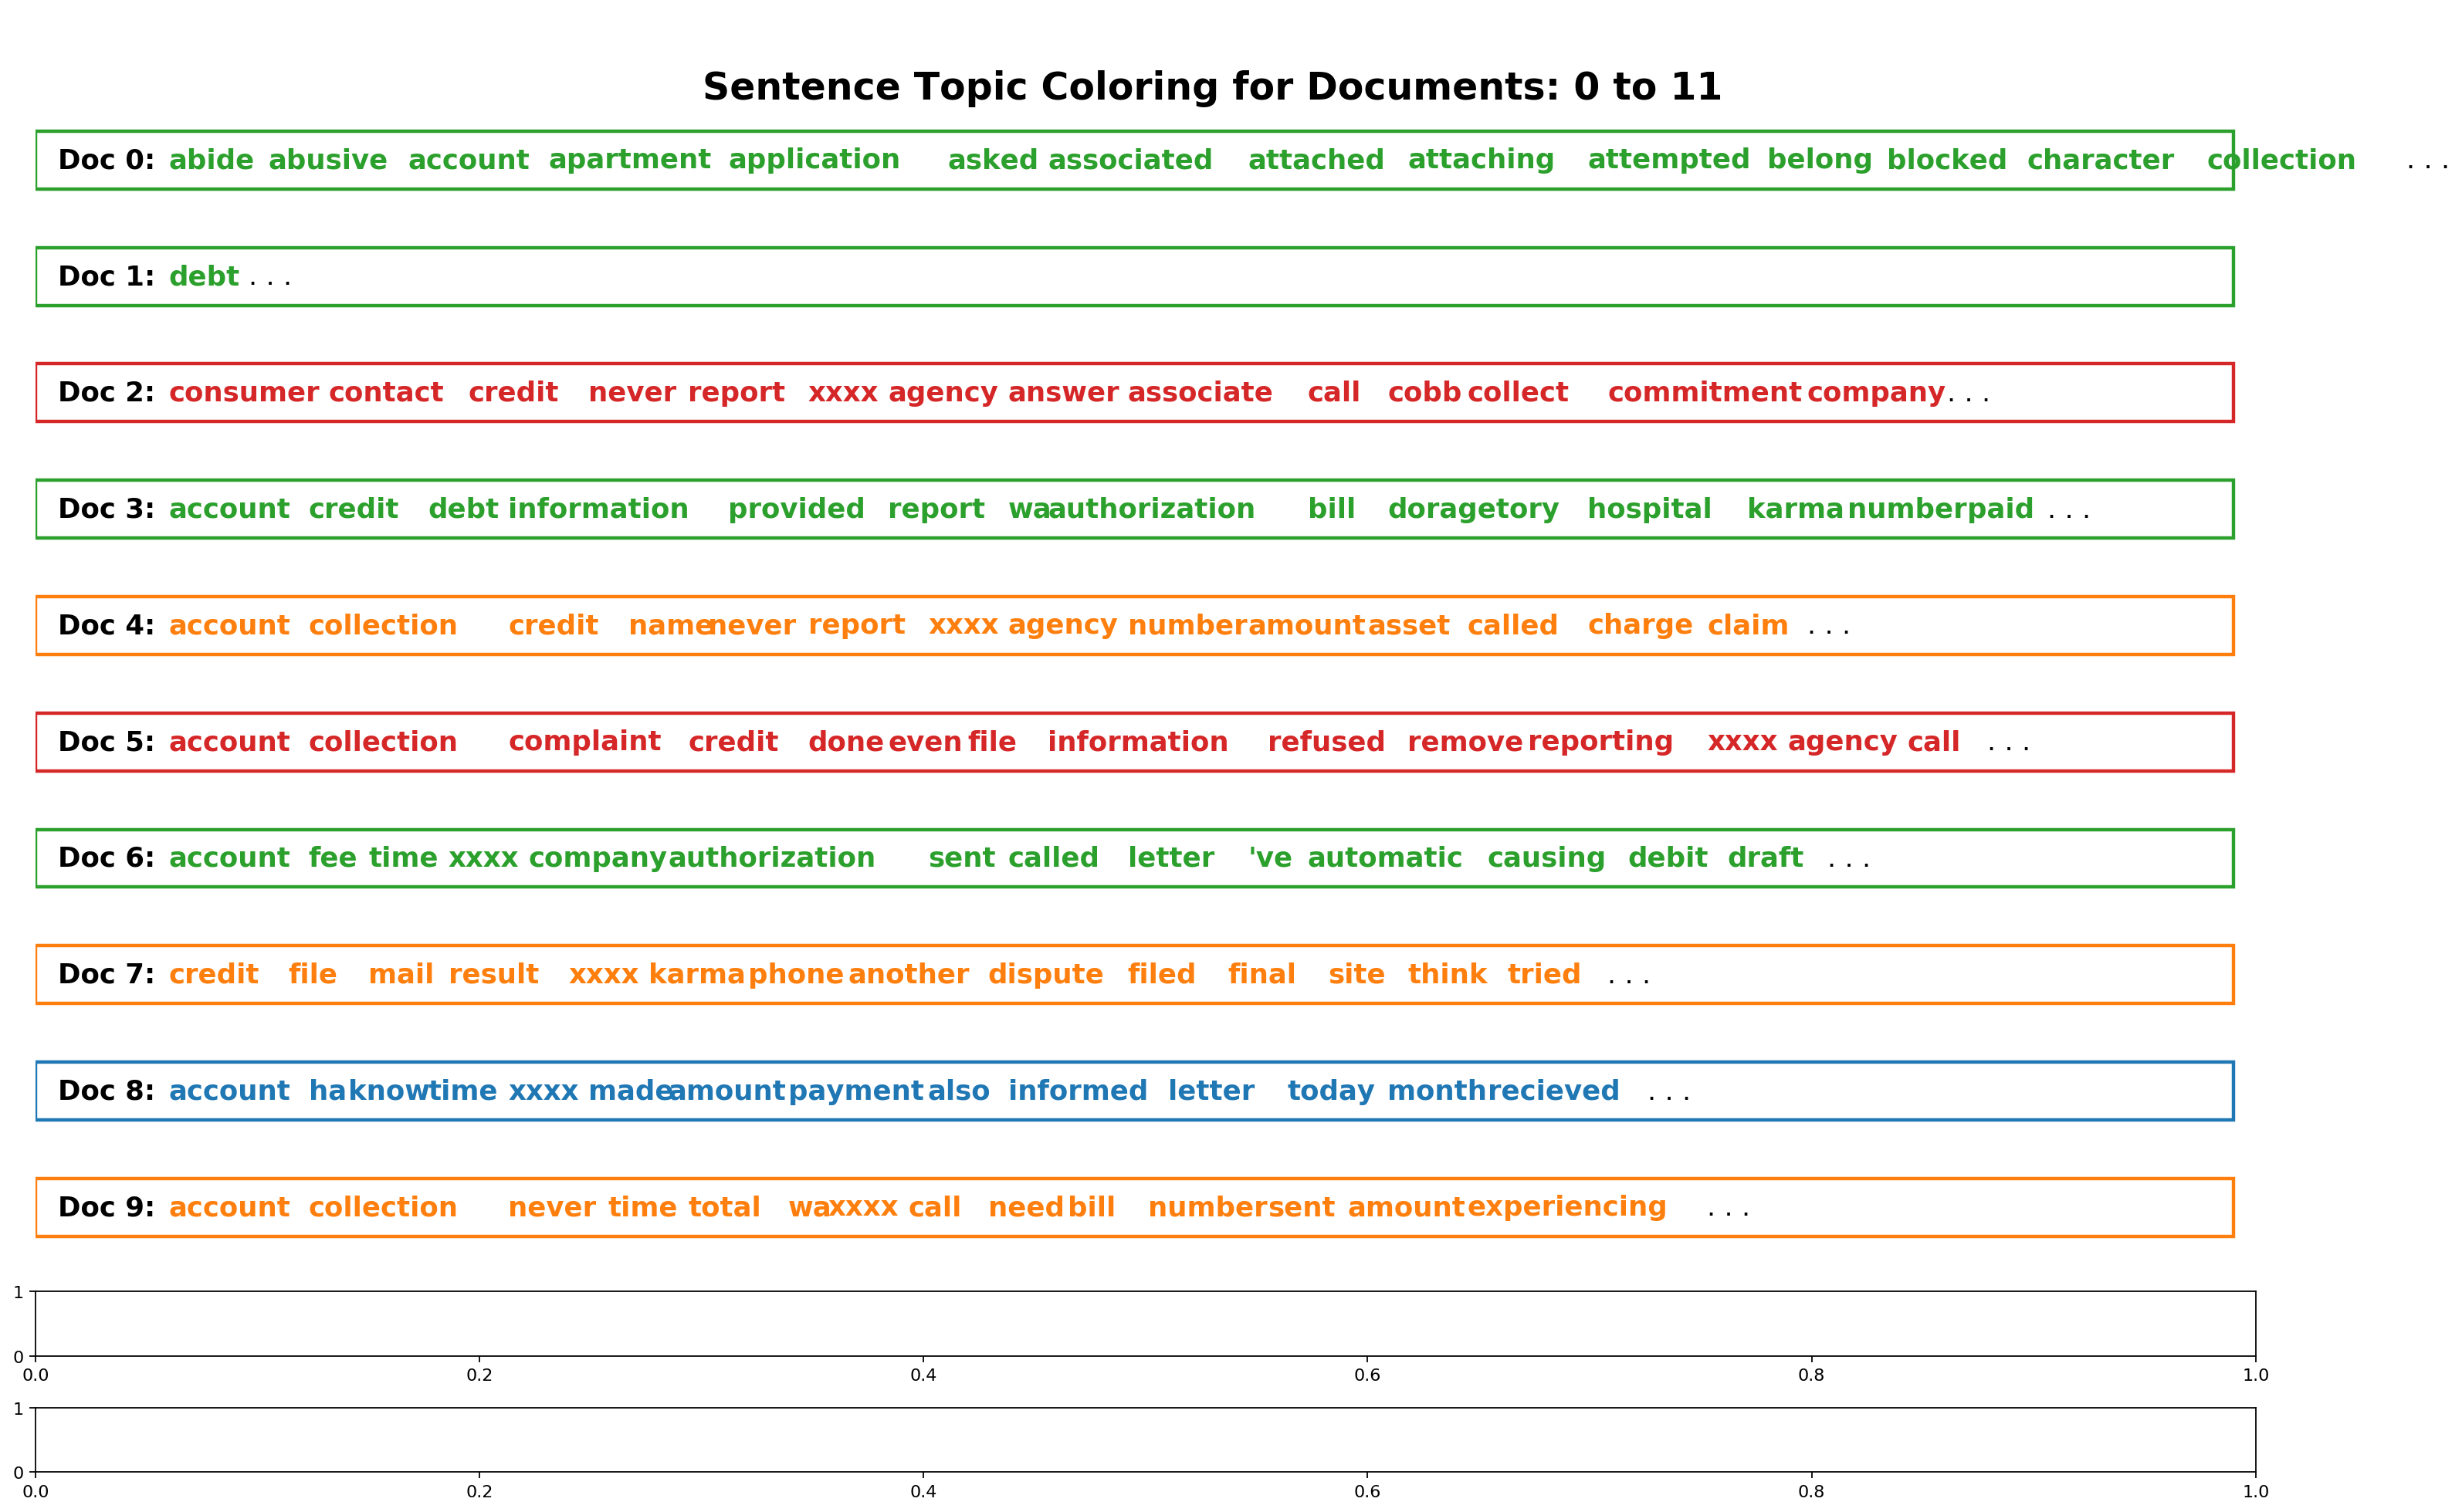

In [45]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=mycorpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            try:
                corp_cur = corp[i-1] 
                topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
                word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
                ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                        fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

                # Draw Rectange
                topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
                ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                       color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

                word_pos = 0.06
                for j, (word, topics) in enumerate(word_dominanttopic):
                    if j < 14:
                        ax.text(word_pos, 0.5, word,
                                horizontalalignment='left',
                                verticalalignment='center',
                                fontsize=16, color=mycolors[topics],
                                transform=ax.transAxes, fontweight=700)
                        word_pos += .009 * len(word)  # to move the word for the next iter
                        ax.axis('off')
                ax.text(word_pos, 0.5, '. . .',
                        horizontalalignment='left',
                        verticalalignment='center',
                        fontsize=16, color='black',
                        transform=ax.transAxes)       
            except:pass
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [47]:
import numpy as np
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[mycorpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.010612
[t-SNE] KL divergence after 750 iterations: 0.219580
